In [40]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
from datasets import load_dataset

In [62]:
dataset = load_dataset('sst2')

In [73]:
# Using HuggingFace Datasets
dataset = dataset.map(lambda example: {'text': example['sentence']})

train_df = pd.DataFrame(dataset['train'])
val_df = pd.DataFrame(dataset['validation'])

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

In [66]:
X_train = train_df['text'].values
y_train = train_df['label'].values
X_val = val_df['text'].values
y_val = val_df['label'].values

In [26]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2025-04-11 09:14:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-04-11 09:14:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-04-11 09:14:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [23]:
from tensorflow.keras.layers import Input, Embedding, Reshape, Conv2D, MaxPooling2D, Concatenate, Flatten, Dropout, Dense
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [7]:
# Hyperparameters from the paper
vocab_size = 5000
embedding_dim = 300
maxlen = 100
num_filters = 100
kernel_sizes = [3, 4, 5]

In [67]:
# Tokenize the text data
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<oov>')
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

In [68]:
# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen)
X_val_pad = pad_sequences(X_val_seq, maxlen=maxlen)

In [69]:
embeddings_index = {}
with open('glove.6B.300d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [70]:
# Building the CNN model

# Input layer
input_layer = Input(shape=(maxlen,))
embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(input_layer)

# Reshape for Conv2D: (batch, height, width, channels) -> (batch, maxlen, embedding_dim, 1)
reshape = Reshape((maxlen, embedding_dim, 1))(embedding)

# Define Conv2D + MaxPooling layers with kernel sizes (3, embedding_dim), etc.
conv_3 = Conv2D(filters=num_filters, kernel_size=(3, embedding_dim), activation='relu')(reshape)
conv_4 = Conv2D(filters=num_filters, kernel_size=(4, embedding_dim), activation='relu')(reshape)
conv_5 = Conv2D(filters=num_filters, kernel_size=(5, embedding_dim), activation='relu')(reshape)

# MaxPooling over time dimension
pool_3 = MaxPooling2D(pool_size=(maxlen - 3 + 1, 1))(conv_3)
pool_4 = MaxPooling2D(pool_size=(maxlen - 4 + 1, 1))(conv_4)
pool_5 = MaxPooling2D(pool_size=(maxlen - 5 + 1, 1))(conv_5)

# Concatenate and flatten
concat = Concatenate(axis=-1)([pool_3, pool_4, pool_5])
flatten = Flatten()(concat)
drop = Dropout(0.5)(flatten)

# Dense layers
dense = Dense(128, activation='relu', kernel_constraint=MaxNorm(3))(drop)
output = Dense(1, activation='sigmoid')(dense)

# Model compilation
model_cnn = Model(inputs=input_layer, outputs=output)
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


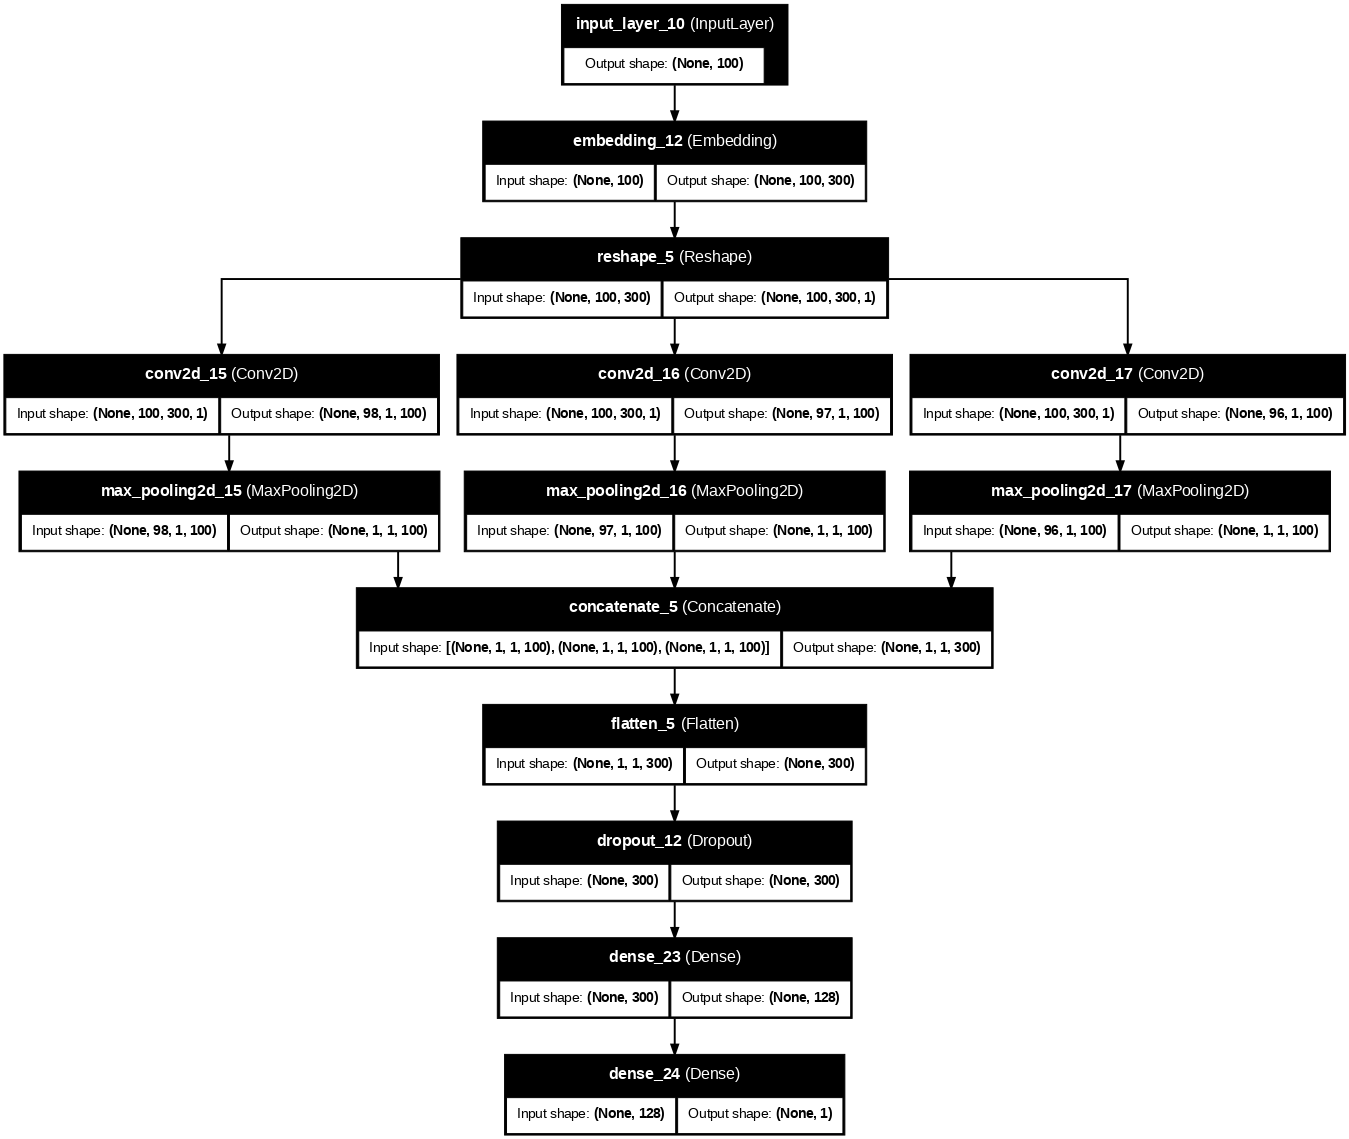

In [71]:
# Using plot_model to view this model

from tensorflow.keras.utils import plot_model
plot_model(model_cnn, to_file='model_plot_cnn.png', show_shapes=True, show_layer_names=True, dpi=70)

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
model_checkpoint_cnn = ModelCheckpoint(
    filepath="sentiment_analysis_cnn.keras",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True
)

# Train the model
history_cnn = model_cnn.fit(X_train_pad, y_train, epochs=5, batch_size=50, validation_data=(X_val_pad, y_val), callbacks=[model_checkpoint_cnn])

Epoch 1/5
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7857 - loss: 0.4307
Epoch 1: val_loss improved from inf to 0.41544, saving model to sentiment_analysis_cnn.keras
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 16s 9ms/step - accuracy: 0.7858 - loss: 0.4307 - val_accuracy: 0.8154 - val_loss: 0.4154
Epoch 2/5
1346/1347 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8608 - loss: 0.3073
Epoch 2: val_loss did not improve from 0.41544
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8608 - loss: 0.3073 - val_accuracy: 0.8200 - val_loss: 0.4250
Epoch 3/5
1345/1347 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8829 - loss: 0.2672
Epoch 3: val_loss did not improve from 0.41544
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - accuracy: 0.8829 - loss: 0.2672 - val_accuracy: 0.7993 - val_loss: 0.4556
Epoch 4/5
1341/1347 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8982 - loss: 0.2327
Epoch 4: val_loss did not improve from 0.41544
1347/1347 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.898

In [74]:
from tensorflow.keras.layers import LSTM

# Building the LSTM model

model_lstm = Sequential()
model_lstm.add(Input(shape=(maxlen,)))
model_lstm.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))
model_lstm.add(LSTM(128))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(64))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

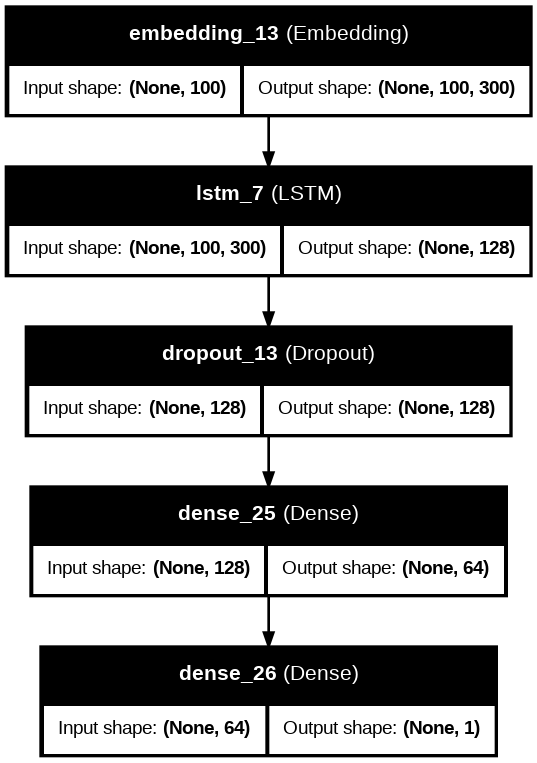

In [75]:
# Using plot_model to view this model

plot_model(model_lstm, to_file='model_plot_lstm.png', show_shapes=True, show_layer_names=True, dpi=96)

In [76]:
# Define the ModelCheckpoint callback
model_checkpoint_lstm = ModelCheckpoint(
    filepath="sentiment_analysis_lstm.keras",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    verbose = 1,
    save_best_only=True
)

# Train the LSTM model
history_lstm = model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_data=(X_val_pad, y_val), callbacks=[model_checkpoint_lstm])

Epoch 1/5
1049/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7809 - loss: 0.4468
Epoch 1: val_loss improved from inf to 0.42239, saving model to sentiment_analysis_lstm.keras
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.7811 - loss: 0.4466 - val_accuracy: 0.8062 - val_loss: 0.4224
Epoch 2/5
1052/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8553 - loss: 0.3186
Epoch 2: val_loss did not improve from 0.42239
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8554 - loss: 0.3186 - val_accuracy: 0.8200 - val_loss: 0.4330
Epoch 3/5
1050/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8781 - loss: 0.2701
Epoch 3: val_loss did not improve from 0.42239
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.8781 - loss: 0.2701 - val_accuracy: 0.8165 - val_loss: 0.4689
Epoch 4/5
1051/1053 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8984 - loss: 0.2288
Epoch 4: val_loss did not improve from 0.42239
1053/1053 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.

In [86]:
# Prediction on CNN

def predict_sentiment(sentence):
    # Load the saved model
    pred_model = keras.models.load_model("sentiment_analysis_cnn.keras")

    # Tokenize the sentence
    sequence = tokenizer.texts_to_sequences([sentence])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)

    # Make the prediction
    prediction = pred_model.predict(padded_sequence)[0][0]

    # Classify the sentiment
    if prediction >= 0.5:
        return ["Positive", prediction]
    else:
        return ["Negative", prediction]

# Example usage:
while True:
    input_sentence = input("Enter a sentence (or 'exit' to quit): ")
    if input_sentence.lower() == 'exit':
        break
    sentiment = predict_sentiment(input_sentence)
    print("Sentiment:", sentiment[0])
    print("Probability:", sentiment[1])

Enter a sentence (or 'exit' to quit): i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
Sentiment: Positive
Probability: 0.9255345
Enter a sentence (or 'exit' to quit): i hate you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
Sentiment: Negative
Probability: 0.29088897
Enter a sentence (or 'exit' to quit): you are the best
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 413ms/step
Sentiment: Positive
Probability: 0.9775423
Enter a sentence (or 'exit' to quit): he is bad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
Sentiment: Negative
Probability: 0.08604368
Enter a sentence (or 'exit' to quit): exit


In [87]:
# Prediction on LSTM

def predict_sentiment(sentence):
    # Load the saved model
    pred_model = keras.models.load_model("sentiment_analysis_lstm.keras")

    # Tokenize the sentence
    sequence = tokenizer.texts_to_sequences([sentence])

    # Pad the sequence
    padded_sequence = pad_sequences(sequence, maxlen=maxlen)

    # Make the prediction
    prediction = pred_model.predict(padded_sequence)[0][0]

    # Classify the sentiment
    if prediction >= 0.5:
        return ["Positive", prediction]
    else:
        return ["Negative", prediction]

# Example usage:
while True:
    input_sentence = input("Enter a sentence (or 'exit' to quit): ")
    if input_sentence.lower() == 'exit':
        break
    sentiment = predict_sentiment(input_sentence)
    print("Sentiment:", sentiment[0])
    print("Probability:", sentiment[1])

Enter a sentence (or 'exit' to quit): i love you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
Sentiment: Positive
Probability: 0.954494
Enter a sentence (or 'exit' to quit): i hate you
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Sentiment: Negative
Probability: 0.41809297
Enter a sentence (or 'exit' to quit): you are the best
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Sentiment: Positive
Probability: 0.97683245
Enter a sentence (or 'exit' to quit): he is bad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Sentiment: Negative
Probability: 0.02018524
Enter a sentence (or 'exit' to quit): exit
